Doesn't look identical, but not all parameters are specified (i.e. infectious seed).
Immune population seems to be interpreted as both the infectious and the recovered compartment, given the outputs.

In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

from summer2 import CompartmentalModel
from summer2.parameters import Parameter

In [2]:
def build_seir_model(
    config: dict,
) -> CompartmentalModel:

    # Model characteristics
    compartments = (
        "Susceptible", 
        "Pre-infectious", 
        "Infectious", 
        "Immune"
    )
    model = CompartmentalModel(
        times=(0., config["end_time"]),
        compartments=compartments,
        infectious_compartments=["Infectious"],
    )
    model.set_initial_population(
        distribution={
            "Susceptible": config["total_population"] - config["infectious_seed"],
            "Infectious": config["infectious_seed"],
        }
    )
    
    # Transitions
    infectious_period = Parameter("infectious_period")
    model.add_infection_frequency_flow(
        name="infection", 
        contact_rate=Parameter("r0") / infectious_period,
        source="Susceptible",
        dest="Pre-infectious"
    )
    model.add_transition_flow(
        name="progression", 
        fractional_rate=1. / Parameter("latent_period"),
        source="Pre-infectious", 
        dest="Infectious"
    )
    model.add_transition_flow(
        name="recovery", 
        fractional_rate=1. / infectious_period,
        source="Infectious", 
        dest="Immune"
    )
    
    # Output
    model.request_output_for_flow(
        name="incidence", 
        flow_name="progression"
    )
    
    return model

In [3]:
model_config = {
    "total_population": 1e5,
    "infectious_seed": 1.,  # Not specified in text
    "end_time": 120.,
}

parameters = {
    "r0": 13.,
    "latent_period": 7.,
    "infectious_period": 8.,
}

In [4]:
measles_model = build_seir_model(model_config)
measles_model.run(parameters=parameters, solver="euler")

#### Left panel - measles

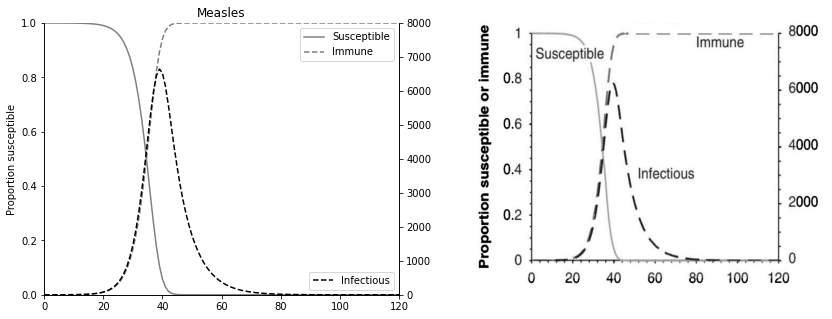

In [5]:
fig, (left_ax, right_ax) = plt.subplots(1, 2, figsize=(14, 5))
twin_ax = left_ax.twinx()

left_ax.plot(
    measles_model.times,
    measles_model.get_outputs_df()["Susceptible"] / model_config["total_population"],
    color="0.5",
    label="Susceptible",
)
left_ax.plot(
    measles_model.times,
    1. - measles_model.get_outputs_df()["Susceptible"] / model_config["total_population"],
    color="0.5",
    label="Immune",
    linestyle="--",
)
left_ax.set_xlim(0., 120.)
left_ax.set_ylim(0., 1.)
left_ax.set_ylabel("Proportion susceptible")
left_ax.legend()
left_ax.set_title("Measles")
left_ax.spines.top.set_visible(False)

twin_ax.plot(
    measles_model.times,
    measles_model.get_derived_outputs_df()["incidence"], 
    color="0", 
    linestyle="--",
    label="Infectious",
)
twin_ax.set_ylim(0., 8000.)
twin_ax.legend(loc=4)
twin_ax.spines.top.set_visible(False)

image = plt.imread("./figures/fig_4_4_measles.jpg")
right_ax.imshow(image, aspect="auto")
right_ax.axis("off");

In [6]:
parameters = {
    "r0": 2.,
    "infectious_period": 2.,
    "latent_period": 2.,
}

flu_model = build_seir_model(model_config)
flu_model.run(parameters=parameters, solver="euler")

#### Right panel - influenza

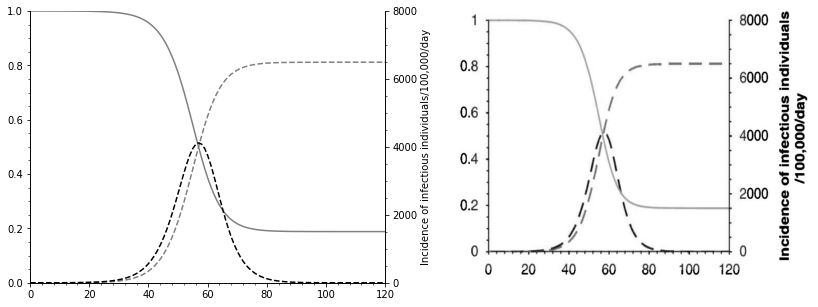

In [7]:
fig, (left_ax, right_ax) = plt.subplots(1, 2, figsize=(14, 5))
twin_ax = left_ax.twinx()

left_ax.plot(
    flu_model.times, 
    flu_model.get_outputs_df()["Susceptible"] / model_config["total_population"],
    color="0.5",
    label="Susceptible",
)
left_ax.plot(
    flu_model.times, 
    1. - flu_model.get_outputs_df()["Susceptible"] / model_config["total_population"],
    color="0.5",
    label="Immune",
    linestyle="--",
)
left_ax.set_xlim(0., 120.)
left_ax.xaxis.set_minor_locator(AutoMinorLocator(5))
left_ax.set_ylim(0., 1.)
left_ax.yaxis.set_minor_locator(AutoMinorLocator(4))
left_ax.spines.top.set_visible(False)

twin_ax.plot(
    flu_model.times, 
    flu_model.get_derived_outputs_df()["incidence"], 
    color="0", 
    linestyle="--",
    label="Incidence",
)
twin_ax.set_ylim(0., 8000.)
twin_ax.set_yticks(range(0, 10000, 2000))
twin_ax.yaxis.set_minor_locator(AutoMinorLocator(4))
twin_ax.set_ylabel("Incidence of infectious individuals/100,000/day")
twin_ax.spines.top.set_visible(False)

image = plt.imread("./figures/fig_4_4_flu.jpg")
right_ax.imshow(image, aspect="auto")
right_ax.axis("off");